
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

### Soft Data Debiasing 

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Here's a simple workflow for soft data debiasing. This step is critical for:

* calculating representative distributions with imputation of missing parts of the distribution

#### Load the Required Libraries

The following code loads the required libraries including my GeostatsPy package.

In [1]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
ignore_warnings = True
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, AutoLocator) # control of axes ticks
import matplotlib.patches as patches
import seaborn as sns
cmap = plt.cm.inferno                                     # set color map
import scipy.stats as st                                  # statistical methods
from scipy.interpolate import make_interp_spline          # smooth curves
plt.rc('axes', axisbelow=True)                            # plot all grids below the plot elements
if ignore_warnings == True:
    import warnings
    warnings.filterwarnings('ignore')

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

In [3]:
xmin=0; xmax=1000; ymin=0; ymax=1000
def regular_sample(array,array2,xmin,xmax,ymin,ymax,spacing,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value',name2='Value2'):
    x = []; y = []; v = []; w = []
    nx = array.shape[1]; ny = array.shape[0]
    xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
    xmn = xmin + 0.5*xsiz; ymn = ymin + 0.5*ysiz
    xx, yy = np.meshgrid(np.arange(xmin, xmax, spacing), np.arange(ymax, ymin, -1 * spacing))
    xx = xx + spacing*0.5; yy = yy - spacing*0.5
    for ix,iy in np.ndindex(xx.shape):
        iix = geostats.getindex(nx,xmn,xsiz,xx[iy,ix])
        iiy = geostats.getindex(ny,ymn,ysiz,yy[iy,ix])
        if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy: 
            if xx[iy,ix] >= minsx and xx[iy,ix] >= minsx: 
                x.append(xx[iy, ix])
                y.append(yy[iy, ix])
                v.append(array[ny - iiy - 1, iix])
                w.append(array2[ny - iiy - 1, iix])
    df = pd.DataFrame(np.c_[x,y,v,w], columns=["X","Y",name,name2])
    return df

def random_sample(array,array2,xmin,xmax,ymin,ymax,nsamp=10,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value',name2='Value2'):
    x = []; y = []; v = []; w = []
    ny, nx = array.shape   
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax,(xmax-xmin)/float(nx)), np.arange(ymax - 1, ymin - 1, -1 * (ymax-ymin)/float(ny))
    )
    mask = np.zeros([ny,nx])
    for iy in range(0,ny):
        for ix in range(0,nx):
            if xx[iy,ix] >= minsx and xx[iy,ix] <= maxsx:
                if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy:
                    mask[iy,ix] = 1.0
    
    if nsamp*1.2 > np.sum(mask):
        print('ERROR - too few locations available for number of samples requested!') 
        return pd.DataFrame()
    isamp = 0
    while isamp < nsamp:
        sample_index = np.random.choice(range(nx * ny), 1)
        iy = int(sample_index[0] / ny)
        ix = sample_index[0] - iy * nx
        if mask[iy,ix] == 1:    
            if xx[iy,ix] >= xmin and xx[iy,ix] <= xmax:
                if yy[iy,ix] >= ymin and yy[iy,ix] <= ymax:        
                    x.append(xx[iy, ix])
                    y.append(yy[iy, ix])
                    v.append(array[iy, ix])
                    w.append(array2[iy, ix])
                    mask[iy,ix] = 0.0
                    isamp = isamp + 1
    df = pd.DataFrame(np.c_[x,y,v,w], columns=["X","Y",name,name2])
    return df

def rejection_sample(df,vcol,frac,wt_min,wt_max):
    value = [np.min(df[vcol].values),np.max(df[vcol].values)]
    wt = [wt_min,wt_max]
    df_copy = df.copy(deep = True)
    df[vcol] = df[vcol]*df[vcol]
    df_copy['weights'] = np.interp(df[vcol],value,wt)
#     plt.scatter(df_copy[vcol],df_copy['weights'])
#     plt.show()
#     print(df_copy.head(n=30))
    df_sample = df_copy.sample(frac = frac, replace = False, weights = 'weights')
    return df_sample

def add_grid(sub_plot):
    sub_plot.grid(True, which='major',linewidth = 1.0); sub_plot.grid(True, which='minor',linewidth = 0.2) # add y grids
    sub_plot.tick_params(which='major',length=7); sub_plot.tick_params(which='minor', length=4)
    sub_plot.xaxis.set_minor_locator(AutoMinorLocator()); sub_plot.yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [4]:
#os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extract a limited sample to reduce data density. This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [5]:
#df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
# df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
# df = df.sample(50)                                        # extract 50 samples
# df = df.reset_index()                                     # reset the record index 
# df = df.drop(['index','Unnamed: 0','Perm'],axis=1)               # remove extra columns in DataFrame
# df.head()

Let's check the summary statistics to set the plotting minimum and maximum values.

In [6]:
# df.describe().transpose()                                 # summary statistics 

Now we can set these values for plotting:

In [7]:
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0
pormin = 0.0; pormax = 0.35; AImin = 0.0; AImax = 8000.0

Let's look at the data before we simulate. Note, we visualize permeability with a natural log transform to improve interpretation, but all of our workflow steps are conducted in the regular feature space.

In [8]:
# plt.subplot(131)                                          # plot the results
# GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Location Map - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
# plt.grid()

# plt.subplot(132)
# GSLIB.locmap_st(df,'X','Y','AI',xmin,xmax,ymin,ymax,AImin,AImax,'Location Map - AI','X(m)','Y(m)','Acoustic Impedance (m/s x g/cm^3)',cmap)
# plt.grid()

# plt.subplot(133)
# plt.scatter(df['Porosity'].values,df['AI'].values,color='black',alpha=0.5)
# plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic Impedance (m/s x g/cm^3)');plt.title('Acoustic Impedance vs. Porosity')
# plt.xlim([pormin,pormax]); plt.ylim([AImin,AImax]); plt.grid()

# plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Visualize porosity and permeability realizations and the porosity vs. permeability relationship for independently simulation realizations.

#### Sequential Gaussian Simulation - Collocated Cokriging

Now let's demonstrate collocated cokriging.  We first calculate a realization of porosity and then collocated cokriging realization of permeability constrained to the porosity realizations.

In [9]:
run_sim = True
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 100; ktype = 0; skmean = 0
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=100,hmin1=100)
tmin = -99999; tmax = 99999
    
n = 100                                         # Reference distribution
df_ref = pd.DataFrame(np.vstack([np.random.rand(n)*(xmax-xmin)+xmin-10**7,
                             np.random.rand(n)*(ymax-ymin)+ymin,
                             np.random.normal(loc = 0.15,scale=0.03,size=n),
                             np.random.normal(loc = 3000,scale=1000,size=n)]).T, columns= ['X','Y','Porosity','AI'])
 
if run_sim == True:
    sim_por = geostats.sgsim(df_ref,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
                twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=pormin,utail=1,utpar=pormax,nsim=1,
                nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
                ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
                mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=None,vario=vario)
    
    cosim_AI = geostats.sgsim(df_ref,'X','Y','AI',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
                twtcol=0,zmin=AImin,zmax=AImax,ltail=1,ltpar=AImin,utail=1,utpar=AImax,nsim=1,
                nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73075,
                ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
                mxctx=10,mxcty=10,ktype=4,colocorr=-0.7,sec_map=sim_por,vario=vario)
    
plt.subplot(221)
GSLIB.pixelplt_st(sim_por,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,'Truth Model','X (m)','Y (m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.hist_st(sim_por.flatten(),pormin,pormax,0,0,20,None,'Porosity (%)','Truth Model')

plt.subplot(222)
GSLIB.pixelplt_st(cosim_AI,xmin,xmax,ymin,ymax,xsiz,AImin,AImax,'Truth Model','X (m)','Y (m)','Acoustic Impedance (m/s x g/cm^3)',cmap)

plt.subplot(224)
GSLIB.hist_st(cosim_AI.flatten(),AImin,AImax,0,0,20,None,'Acoustic Impedance (m/s x g/cm^3)','Truth Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.2); plt.show()

TypeError: sgsim() got an unexpected keyword argument 'radius'

In [ ]:
# Data Set Sampling Paramters
spacing = 10                              # spacing of regular samples
nrandom_sample = 1000                      # number of random samples
wt_min = 0.01; wt_max = 10.0                # weigths of minimum and maximum feature values - control on degree of bias 
bias_frac = 0.9                           # fration of dataset to remove with rejection sampler
max_primary = 3000
seed = 73073                              # random number seed

np.random.seed(seed = seed)               # set the random number seed for repeatability of samples

# Regular Sampling
df_regular_samples = regular_sample(sim_por,cosim_AI,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,spacing=spacing,
                         minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Porosity',name2='AI')

# Random Sampling
df_random_samples = random_sample(sim_por,cosim_AI,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
                                     nsamp = nrandom_sample,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Porosity',name2='AI')

# Concatenate (Combine) Regular and Random Samples into One DataFrame  
df_samples = pd.concat([df_regular_samples,df_random_samples])

# Rejection Sampler
df_biased_samples = rejection_sample(df_samples,'Porosity',1-bias_frac,wt_min,wt_max)

# Remove Dupicates 
df_biased_samples = df_biased_samples[np.invert(df_biased_samples.duplicated(subset=['X','Y'],keep='first'))] 

# Remove Values Below the Minimum Mask
df_biased_samples = df_biased_samples[df_biased_samples['AI'] < max_primary]

df_truth = pd.DataFrame(np.vstack([sim_por.flatten(),cosim_AI.flatten()]).T, columns= ['Porosity','AI'])

plt.subplot(131)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Samples and Truth Model')  
plt.imshow(sim_por,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = pormin, vmax = pormax,cmap = cmap)
plt.scatter(df_biased_samples['X'],df_biased_samples['Y'],c = df_biased_samples['Porosity'],s = 20, cmap = cmap,vmin = pormin, vmax = pormax, 
                        edgecolors = 'black',label = 'Porosity (%)')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar(); cbar.set_label('Porosity (fraction)'); ax4.set_aspect('auto')

plt.subplot(132)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Samples and Truth Model')  
plt.imshow(cosim_AI,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = AImin, vmax = AImax,cmap = cmap)
plt.scatter(df_biased_samples['X'],df_biased_samples['Y'],c = df_biased_samples['AI'],s = 20, cmap = cmap,vmin = AImin, vmax = AImax, 
                        edgecolors = 'black',label = 'Porosity (%)')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar(); cbar.set_label(r'Acoustic Impedance ($\frac{m}{s} \times \frac{g}{cm^3} \times 10^3$)'); ax4.set_aspect('auto')
    
plt.subplot(133)
plt.scatter(cosim_AI,sim_por.flatten(),color='red',s=10,alpha=0.2,zorder=1)
plt.scatter(df_biased_samples['AI'].values,df_biased_samples['Porosity'].values,color='black',s=10,alpha=0.5,zorder=10)
plt.ylabel('Porosity (fraction)'); plt.xlabel(r'Acoustic Impedance ($\frac{m}{s} \times \frac{g}{cm^3} \times 10^3$)');plt.title('Acoustic Impedance vs. Porosity')
plt.ylim([pormin,pormax]); plt.xlim([AImin,AImax]); plt.grid()
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()    

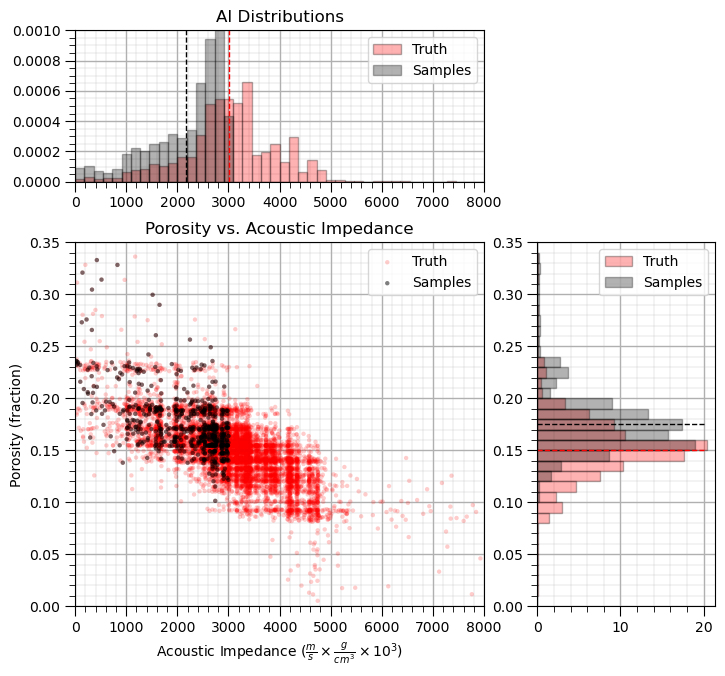

In [11]:
cond = True; cond_P10_init = 4000.0; cond_P90_init = 9000.0; cond_exp_init = 6000.0
por_extrap = 0.21; cond_P10_final = 500.0; cond_P90_final = 1500.0; cond_exp_final = 1000.0

plt_scatter = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
plt_x1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,sharex=plt_scatter)
plt_x2 = plt.subplot2grid((3, 3), (1, 2), rowspan=2,sharey=plt_scatter)    

plt_scatter.scatter(cosim_AI.flatten(),sim_por.flatten(),color='red',edgecolors="none",s=10,alpha=0.2,zorder=1,
                    label='Truth')
plt_scatter.scatter(df_biased_samples['AI'].values,df_biased_samples['Porosity'].values,color='black',edgecolors="none",
                    s=10,alpha=0.5,zorder=10,label='Samples')
plt_scatter.legend(loc='upper left') 
plt_scatter.set_ylim([pormin,pormax]); plt_scatter.set_xlim([AImin,AImax]); add_grid(plt_scatter)

plt_scatter.set_ylabel('Porosity (fraction)'); plt_scatter.set_xlabel(r'Acoustic Impedance ($\frac{m}{s} \times \frac{g}{cm^3} \times 10^3$)');
plt_scatter.set_title('Porosity vs. Acoustic Impedance'); plt_scatter.legend(loc='upper right')

if cond == True:
    nbins = 6
    X1_new = np.linspace(0.0,0.22,300)            # for smooth splines
    X1_bins = np.linspace(0.0,0.2,nbins)      # set the bin boundaries and then the centroids for plotting
    X1_centroids = np.linspace((X1_bins[0]+X1_bins[1])*0.5,(X1_bins[-2]+X1_bins[-1])*0.5,nbins-1)
    df_truth['por_bins'] = pd.cut(df_truth['Porosity'], X1_bins,labels = X1_centroids) # cut on bondaries and lable with centroids 
    
    cond_exp = df_truth.groupby('por_bins')['AI'].mean()
    cond_P90 = df_truth.groupby('por_bins')['AI'].quantile(.9)
    cond_P10 = df_truth.groupby('por_bins')['AI'].quantile(.1)
   
    cond_P90.iloc[0] = cond_P90_init; cond_P10.iloc[0] = cond_P10_init; cond_exp.iloc[0] = cond_exp_init
    X1_centroids = np.append(X1_centroids,por_extrap)
    
    cond_P90_final_s = pd.Series([cond_P90_final],[por_extrap])
    cond_P10_final_s = pd.Series([cond_P10_final],[por_extrap])
    cond_exp_final_s = pd.Series([cond_exp_final],[por_extrap])
    
    cond_P90 = cond_P90.append(cond_P90_final_s)
    cond_P10 = cond_P10.append(cond_P10_final_s)
    cond_exp = cond_exp.append(cond_exp_final_s)
   
    spl_exp = make_interp_spline(X1_centroids, cond_exp, k=3)
    spl_P90 = make_interp_spline(X1_centroids, cond_P90, k=3)
    spl_P10 = make_interp_spline(X1_centroids, cond_P10, k=3)
    cond_exp_spl = spl_exp(X1_new); cond_P90_spl = spl_P90(X1_new); cond_P10_spl = spl_P10(X1_new)

    plt_scatter.plot(X1_new,cond_exp_spl,color='white',lw=4,zorder=100)
    plt_scatter.plot(X1_new,cond_exp_spl,color='black',lw=2,zorder=200)
    plt_scatter.plot(X1_new,cond_P90_spl,color='white',lw = 4,zorder=100)
    plt_scatter.plot(X1_new,cond_P90_spl,color='black',lw = 2,ls='--',zorder=200)
    plt_scatter.plot(X1_new,cond_P10_spl,color='white',lw = 4,zorder=100)
    plt_scatter.plot(X1_new,cond_P10_spl,color='black',lw = 2,ls='--',zorder=200)
     
    plt_scatter.scatter(X1_centroids[0],cond_P90.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[0],cond_P10.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[0],cond_exp.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000) 
    plt_scatter.scatter(X1_centroids[-1],cond_P90.iloc[len(cond_P90)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[-1],cond_P10.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[-1],cond_exp.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    
#     plt_scatter.annotate('Exp',[X1_new[0]-0.3,cond_exp_spl[0]]); plt_scatter.annotate('Exp',[X1_new[-1]+0.05,cond_exp_spl[-1]])
#     plt_scatter.annotate('P10',[X1_new[0]-0.3,cond_P10_spl[0]]); plt_scatter.annotate('P10',[X1_new[-1]+0.05,cond_P10_spl[-1]])
#     plt_scatter.annotate('P90',[X1_new[0]-0.3,cond_P90_spl[0]]); plt_scatter.annotate('P90',[X1_new[-1]+0.05,cond_P90_spl[-1]])

plt_x1.hist(cosim_AI.flatten(),density = True,color='red',alpha=0.3,edgecolor='black',
            bins=np.linspace(AImin,AImax,45),label='Truth')
plt_x1.hist(df_biased_samples['AI'].values,density = True,color='black',alpha=0.3,edgecolor='black',
             bins=np.linspace(AImin,AImax,45),label='Samples')
plt_x1.plot([np.average(df_biased_samples['AI'].values),np.average(df_biased_samples['AI'].values)],[0,1],c='black',lw=1,ls='--')
plt_x1.plot([np.average(cosim_AI.flatten()),np.average(cosim_AI.flatten())],[0,1],c='red',lw=1,ls='--')

plt_x1.set_xlim([AImin,AImax]); plt_x1.legend(loc='upper right'); plt_x1.set_ylim([0.0,0.001])
plt_x1.set_title(r'AI Distributions'); add_grid(plt_x1)

plt_x2.hist(sim_por.flatten(),orientation='horizontal',density = True,color='red',alpha=0.3,edgecolor='black',
             bins=np.linspace(pormin,pormax,36),label='Truth')
plt_x2.hist(df_biased_samples['Porosity'].values,orientation='horizontal',density = True,color='black',alpha=0.3,
            edgecolor='black',bins=np.linspace(pormin,pormax,36),label='Samples')
plt_x2.plot([0,20],[np.average(df_biased_samples['Porosity'].values),np.average(df_biased_samples['Porosity'].values)],c='black',lw=1,ls='--')
plt_x2.plot([0,20],[np.average(sim_por.flatten()),np.average(sim_por.flatten())],c='red',lw=1,ls='--')

plt_x2.set_ylim([pormin,pormax]); plt_x2.legend(loc='upper right'); add_grid(plt_x2)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.2, wspace=0.3, hspace=0.4); plt.show()

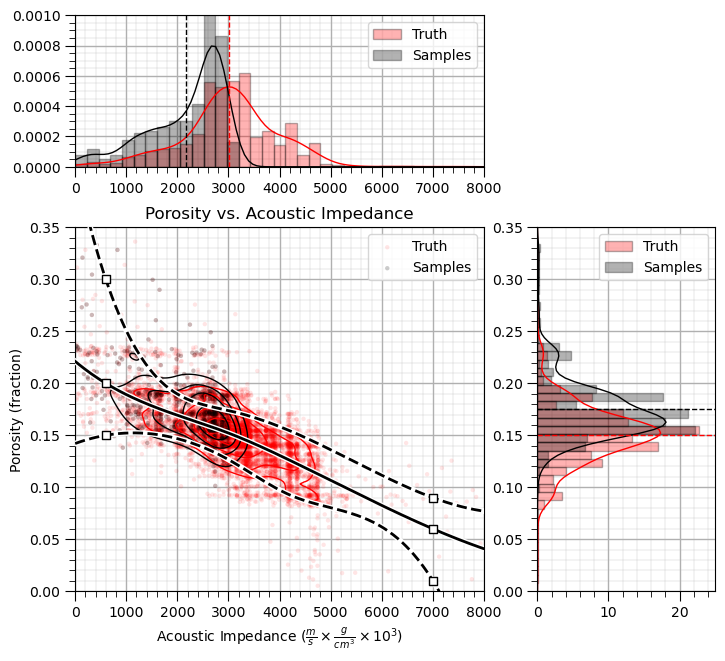

In [12]:
cond = True; cond_P10_init = 0.15; cond_P90_init = 0.3; cond_exp_init = 0.2
AI_extrap = 7000; cond_P10_final = 0.01; cond_P90_final = 0.09; cond_exp_final = 0.06

plt_scatter = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
plt_x1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,sharex=plt_scatter)
plt_x2 = plt.subplot2grid((3, 3), (1, 2), rowspan=2,sharey=plt_scatter)    

plt_scatter.scatter(cosim_AI.flatten(),sim_por.flatten(),color='red',edgecolors="none",s=10,alpha=0.1,zorder=1,
                    label='Truth')
plt_scatter.scatter(df_biased_samples['AI'].values,df_biased_samples['Porosity'].values,color='black',edgecolors="none",
                    s=10,alpha=0.2,zorder=10,label='Samples')
plt_scatter.legend(loc='upper left') 
plt_scatter.set_ylim([pormin,pormax]); plt_scatter.set_xlim([AImin,AImax]); add_grid(plt_scatter)

plt_scatter.set_ylabel('Porosity (fraction)'); plt_scatter.set_xlabel(r'Acoustic Impedance ($\frac{m}{s} \times \frac{g}{cm^3} \times 10^3$)');
plt_scatter.set_title('Porosity vs. Acoustic Impedance'); plt_scatter.legend(loc='upper right')

if cond == True:
    nbins = 6
    X1_new = np.linspace(0.0,8000,300)            # for smooth splines
    X1_bins = np.linspace(0.0,6000,nbins)      # set the bin boundaries and then the centroids for plotting
    X1_centroids = np.linspace((X1_bins[0]+X1_bins[1])*0.5,(X1_bins[-2]+X1_bins[-1])*0.5,nbins-1)
    df_truth['AI_bins'] = pd.cut(df_truth['AI'], X1_bins,labels = X1_centroids) # cut on bondaries and lable with centroids 
    
    cond_exp = df_truth.groupby('AI_bins')['Porosity'].mean()
    cond_P90 = df_truth.groupby('AI_bins')['Porosity'].quantile(.9)
    cond_P10 = df_truth.groupby('AI_bins')['Porosity'].quantile(.1)
   
    cond_P90.iloc[0] = cond_P90_init; cond_P10.iloc[0] = cond_P10_init; cond_exp.iloc[0] = cond_exp_init
    X1_centroids = np.append(X1_centroids,AI_extrap)
    
    cond_P90_final_s = pd.Series([cond_P90_final],[AI_extrap])
    cond_P10_final_s = pd.Series([cond_P10_final],[AI_extrap])
    cond_exp_final_s = pd.Series([cond_exp_final],[AI_extrap])
    
    cond_P90 = cond_P90.append(cond_P90_final_s)
    cond_P10 = cond_P10.append(cond_P10_final_s)
    cond_exp = cond_exp.append(cond_exp_final_s)
   
    spl_exp = make_interp_spline(X1_centroids, cond_exp, k=3)
    spl_P90 = make_interp_spline(X1_centroids, cond_P90, k=3)
    spl_P10 = make_interp_spline(X1_centroids, cond_P10, k=3)
    cond_exp_spl = spl_exp(X1_new); cond_P90_spl = spl_P90(X1_new); cond_P10_spl = spl_P10(X1_new)

    plt_scatter.plot(X1_new,cond_exp_spl,color='white',lw=4,zorder=100)
    plt_scatter.plot(X1_new,cond_exp_spl,color='black',lw=2,zorder=200)
    plt_scatter.plot(X1_new,cond_P90_spl,color='white',lw = 4,zorder=100)
    plt_scatter.plot(X1_new,cond_P90_spl,color='black',lw = 2,ls='--',zorder=200)
    plt_scatter.plot(X1_new,cond_P10_spl,color='white',lw = 4,zorder=100)
    plt_scatter.plot(X1_new,cond_P10_spl,color='black',lw = 2,ls='--',zorder=200)
     
    plt_scatter.scatter(X1_centroids[0],cond_P90.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[0],cond_P10.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[0],cond_exp.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000) 
    plt_scatter.scatter(X1_centroids[-1],cond_P90.iloc[len(cond_P90)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[-1],cond_P10.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    plt_scatter.scatter(X1_centroids[-1],cond_exp.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)

sns.kdeplot(data=df_truth, x="AI", y="Porosity",ax=plt_scatter,levels=[0.2,0.4,0.6,0.8],linewidths=1.0,
            color='red',zorder=50)
sns.kdeplot(data=df_biased_samples, x="AI", y="Porosity",ax=plt_scatter,levels=[0.2,0.4,0.6,0.8],linewidths=1.0,
            color='black',zorder=50)
    
#     plt_scatter.annotate('Exp',[X1_new[0]-0.3,cond_exp_spl[0]]); plt_scatter.annotate('Exp',[X1_new[-1]+0.05,cond_exp_spl[-1]])
#     plt_scatter.annotate('P10',[X1_new[0]-0.3,cond_P10_spl[0]]); plt_scatter.annotate('P10',[X1_new[-1]+0.05,cond_P10_spl[-1]])
#     plt_scatter.annotate('P90',[X1_new[0]-0.3,cond_P90_spl[0]]); plt_scatter.annotate('P90',[X1_new[-1]+0.05,cond_P90_spl[-1]])

plt_x1.hist(cosim_AI.flatten(),density = True,color='red',alpha=0.3,edgecolor='black',
            bins=np.linspace(AImin,AImax,36),label='Truth')
plt_x1.hist(df_biased_samples['AI'].values,density = True,color='black',alpha=0.3,edgecolor='black',
             bins=np.linspace(AImin,AImax,36),label='Samples')

kde = st.gaussian_kde(cosim_AI.flatten(),bw_method=0.3)
plt_x1.plot(np.linspace(AImin,AImax,100),kde(np.linspace(AImin,AImax,100)),c='red',lw=1)

kde = st.gaussian_kde(df_biased_samples['AI'].values,bw_method=0.3)
plt_x1.plot(np.linspace(AImin,AImax,100),kde(np.linspace(AImin,AImax,100)),c='black',lw=1)

plt_x1.plot([np.average(df_biased_samples['AI'].values),np.average(df_biased_samples['AI'].values)],[0,1],c='black',lw=1,ls='--')
plt_x1.plot([np.average(cosim_AI.flatten()),np.average(cosim_AI.flatten())],[0,1],c='red',lw=1,ls='--')

plt_x1.set_xlim([AImin,AImax]); plt_x1.legend(loc='upper right'); plt_x1.set_ylim([0.0,0.001])
add_grid(plt_x1)

plt_x2.hist(sim_por.flatten(),orientation='horizontal',density = True,color='red',alpha=0.3,edgecolor='black',
             bins=np.linspace(pormin,pormax,45),label='Truth')
plt_x2.hist(df_biased_samples['Porosity'].values,orientation='horizontal',density = True,color='black',alpha=0.3,
            edgecolor='black',bins=np.linspace(pormin,pormax,45),label='Samples')

kde = st.gaussian_kde(sim_por.flatten(),bw_method=0.3)
plt_x2.plot(kde(np.linspace(pormin,pormax,100)),np.linspace(pormin,pormax,100),c='red',lw=1)

kde = st.gaussian_kde(df_biased_samples['Porosity'].values,bw_method=0.3)
plt_x2.plot(kde(np.linspace(pormin,pormax,100)),np.linspace(pormin,pormax,100),c='black',lw=1)

plt_x2.plot([0,25],[np.average(df_biased_samples['Porosity'].values),np.average(df_biased_samples['Porosity'].values)],c='black',lw=1,ls='--')
plt_x2.plot([0,25],[np.average(sim_por.flatten()),np.average(sim_por.flatten())],c='red',lw=1,ls='--')

plt_x2.set_ylim([pormin,pormax]); plt_x2.legend(loc='upper right'); add_grid(plt_x2); plt_x2.set_xlim([0,25]);

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.2, wspace=0.3, hspace=0.4); plt.show()

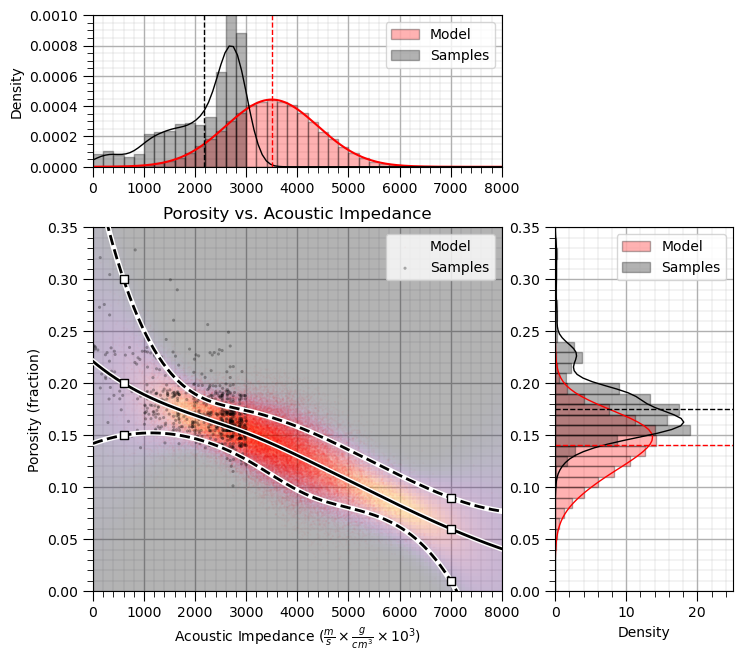

In [13]:
cond = True; cond_P10_init = 0.15; cond_P90_init = 0.3; cond_exp_init = 0.2
AI_extrap = 7000; cond_P10_final = 0.025; cond_P90_final = 0.06; cond_exp_final = 0.04

AI_model_mean = 3500; AI_model_stdev = 900.0

plt_scatter = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
plt_x1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,sharex=plt_scatter)
plt_x2 = plt.subplot2grid((3, 3), (1, 2), rowspan=2,sharey=plt_scatter)    

# plt_scatter.scatter(cosim_AI.flatten(),sim_por.flatten(),color='red',edgecolors="none",s=10,alpha=0.2,zorder=1,
#                     label='Truth')

npor = 100; nAI = 100
porsize = (pormax - pormin)/npor; AIsize = (AImax - AImin)/nAI
pormn = pormin + 0.5*porsize; AImn = AImin + 0.5*AIsize

cond_pdf = np.zeros([nAI,npor])

for ipor, por in enumerate(np.arange(pormn,pormax,porsize)):
    for iAI, AI in enumerate(np.arange(AImn,AImax,AIsize)):   
        por_exp = spl_exp(AI); por_P10 = spl_P10(AI); por_P90 = spl_P90(AI) 
        por_stdev = (por_P90 - por_P10)/2.56310
        cond_pdf[npor - ipor - 1,iAI] = st.norm.pdf(por, loc=por_exp, scale=por_stdev)

plt_scatter.imshow(cond_pdf,alpha=0.3,extent=(AImin,AImax,pormin,pormax),aspect='auto',zorder=1,cmap = plt.cm.inferno) 

plt_scatter.plot(X1_new,cond_exp_spl,color='white',lw=4,zorder=100)
plt_scatter.plot(X1_new,cond_exp_spl,color='black',lw=2,zorder=200)
plt_scatter.plot(X1_new,cond_P90_spl,color='white',lw = 4,zorder=100)
plt_scatter.plot(X1_new,cond_P90_spl,color='black',lw = 2,ls='--',zorder=200)
plt_scatter.plot(X1_new,cond_P10_spl,color='white',lw = 4,zorder=100)
plt_scatter.plot(X1_new,cond_P10_spl,color='black',lw = 2,ls='--',zorder=200)
 
plt_scatter.scatter(X1_centroids[0],cond_P90.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[0],cond_P10.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[0],cond_exp.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000) 
plt_scatter.scatter(X1_centroids[-1],cond_P90.iloc[len(cond_P90)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[-1],cond_P10.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[-1],cond_exp.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    
L = 100000
AI_sample = np.random.normal(loc = AI_model_mean,scale=AI_model_stdev,size = L)
por_sample = np.zeros(len(AI_sample))
por_exp = spl_exp(AI_sample); por_P10 = spl_P10(AI_sample); por_P90 = spl_P90(AI_sample) 
por_stdev = (por_P90 - por_P10)/2.56310
por_sample = np.random.normal(loc=por_exp,scale=por_stdev,size=L)
plt_scatter.scatter(AI_sample,por_sample,color='red',s=2,edgecolors="none",alpha=0.02,label='Model')

plt_scatter.scatter(df_biased_samples['AI'].values,df_biased_samples['Porosity'].values,color='black',edgecolors="none",
                    s=5,alpha=0.3,zorder=10,label='Samples')
plt_scatter.legend(loc='upper right') 
plt_scatter.set_ylim([pormin,pormax]); plt_scatter.set_xlim([AImin,AImax]); add_grid(plt_scatter)

plt_scatter.set_ylabel('Porosity (fraction)'); plt_scatter.set_xlabel(r'Acoustic Impedance ($\frac{m}{s} \times \frac{g}{cm^3} \times 10^3$)');
plt_scatter.set_title('Porosity vs. Acoustic Impedance')    

AI_model_pdf = st.norm.pdf(np.arange(AImin,AImax,10.0),loc=AI_model_mean, scale=AI_model_stdev)
plt_x1.plot(np.arange(AImin,AImax,10.0),AI_model_pdf,color='red')

plt_x1.hist(AI_sample,density = True,color='red',alpha=0.3,edgecolor='black',
            bins=np.linspace(AImin,AImax,41),label='Model')
plt_x1.hist(df_biased_samples['AI'].values,density = True,color='black',alpha=0.3,edgecolor='black',
             bins=np.linspace(AImin,AImax,41),label='Samples')

kde = st.gaussian_kde(df_biased_samples['AI'].values,bw_method=0.3)
plt_x1.plot(np.linspace(AImin,AImax,100),kde(np.linspace(AImin,AImax,100)),c='black',lw=1)

plt_x1.plot([np.average(df_biased_samples['AI'].values),np.average(df_biased_samples['AI'].values)],[0,1],c='black',lw=1,ls='--')
plt_x1.plot([np.average(AI_sample),np.average(AI_sample)],[0,1],c='red',lw=1,ls='--')

plt_x1.set_xlim([AImin,AImax]); plt_x1.legend(loc='upper right'); plt_x1.set_ylim([0.0,0.001])
add_grid(plt_x1); plt_x1.set_ylabel('Density')

plt_x2.hist(por_sample,orientation='horizontal',density = True,color='red',alpha=0.3,edgecolor='black',
             bins=np.linspace(pormin,pormax,36),label='Model')
plt_x2.hist(df_biased_samples['Porosity'].values,orientation='horizontal',density = True,color='black',alpha=0.3,
            edgecolor='black',bins=np.linspace(pormin,pormax,36),label='Samples')

kde = st.gaussian_kde(por_sample,bw_method=0.3)
plt_x2.plot(kde(np.linspace(pormin,pormax,100)),np.linspace(pormin,pormax,100),c='red',lw=1)

kde = st.gaussian_kde(df_biased_samples['Porosity'].values,bw_method=0.3)
plt_x2.plot(kde(np.linspace(pormin,pormax,100)),np.linspace(pormin,pormax,100),c='black',lw=1)

plt_x2.plot([0,25],[np.average(df_biased_samples['Porosity'].values),np.average(df_biased_samples['Porosity'].values)],c='black',lw=1,ls='--')
plt_x2.plot([0,25],[np.average(por_sample),np.average(por_sample)],c='red',lw=1,ls='--')

plt_x2.set_ylim([pormin,pormax]); plt_x2.set_xlim([0,25]); plt_x2.legend(loc='upper right'); add_grid(plt_x2)
plt_x2.set_xlabel('Density'); plt_x2.set_xlim([0,25]);

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.2, wspace=0.3, hspace=0.4); plt.show()

In [ ]:
NOW add a spatial example with AI map, polygon and porosity distribution imputation.

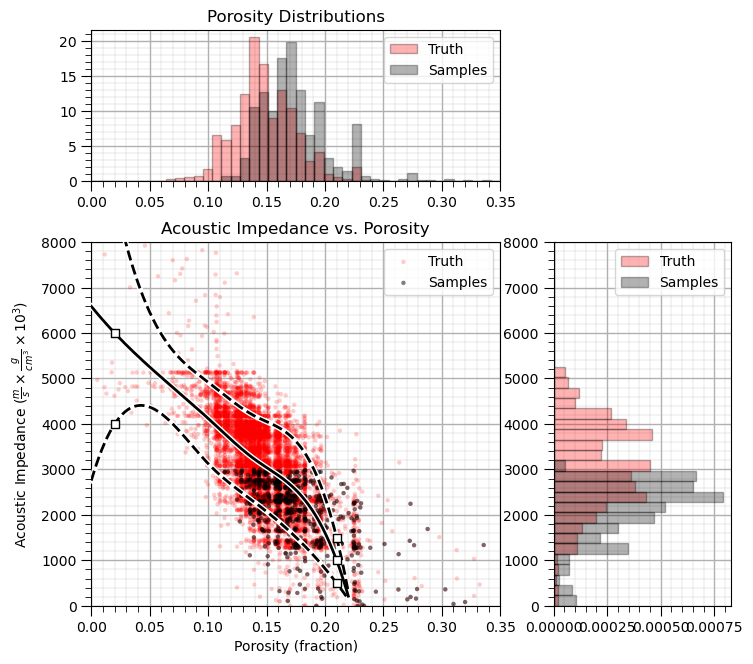

In [82]:
# cond = True; cond_P10_init = 4000.0; cond_P90_init = 9000.0; cond_exp_init = 6000.0
# por_extrap = 0.21; cond_P10_final = 500.0; cond_P90_final = 1500.0; cond_exp_final = 1000.0

# plt_scatter = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
# plt_x1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,sharex=plt_scatter)
# plt_x2 = plt.subplot2grid((3, 3), (1, 2), rowspan=2,sharey=plt_scatter)    

# plt_scatter.scatter(sim_por.flatten(),cosim_AI.flatten(),color='red',edgecolors="none",s=10,alpha=0.2,zorder=1,
#                     label='Truth')
# plt_scatter.scatter(df_biased_samples['Porosity'].values,df_biased_samples['AI'].values,color='black',edgecolors="none",
#                     s=10,alpha=0.5,zorder=10,label='Samples')
# plt_scatter.legend(loc='upper left') 
# plt_scatter.set_xlim([pormin,pormax]); plt_scatter.set_ylim([AImin,AImax]); add_grid(plt_scatter)

# plt_scatter.set_xlabel('Porosity (fraction)'); plt_scatter.set_ylabel(r'Acoustic Impedance ($\frac{m}{s} \times \frac{g}{cm^3} \times 10^3$)');
# plt_scatter.set_title('Acoustic Impedance vs. Porosity'); plt_scatter.legend(loc='upper right')

# if cond == True:
#     nbins = 6
#     X1_new = np.linspace(0.0,0.22,300)            # for smooth splines
#     X1_bins = np.linspace(0.0,0.2,nbins)      # set the bin boundaries and then the centroids for plotting
#     X1_centroids = np.linspace((X1_bins[0]+X1_bins[1])*0.5,(X1_bins[-2]+X1_bins[-1])*0.5,nbins-1)
#     df_truth['por_bins'] = pd.cut(df_truth['Porosity'], X1_bins,labels = X1_centroids) # cut on bondaries and lable with centroids 
    
#     cond_exp = df_truth.groupby('por_bins')['AI'].mean()
#     cond_P90 = df_truth.groupby('por_bins')['AI'].quantile(.9)
#     cond_P10 = df_truth.groupby('por_bins')['AI'].quantile(.1)
   
#     cond_P90.iloc[0] = cond_P90_init; cond_P10.iloc[0] = cond_P10_init; cond_exp.iloc[0] = cond_exp_init
#     X1_centroids = np.append(X1_centroids,por_extrap)
    
#     cond_P90_final_s = pd.Series([cond_P90_final],[por_extrap])
#     cond_P10_final_s = pd.Series([cond_P10_final],[por_extrap])
#     cond_exp_final_s = pd.Series([cond_exp_final],[por_extrap])
    
#     cond_P90 = cond_P90.append(cond_P90_final_s)
#     cond_P10 = cond_P10.append(cond_P10_final_s)
#     cond_exp = cond_exp.append(cond_exp_final_s)
   
#     spl_exp = make_interp_spline(X1_centroids, cond_exp, k=3)
#     spl_P90 = make_interp_spline(X1_centroids, cond_P90, k=3)
#     spl_P10 = make_interp_spline(X1_centroids, cond_P10, k=3)
#     cond_exp_spl = spl_exp(X1_new); cond_P90_spl = spl_P90(X1_new); cond_P10_spl = spl_P10(X1_new)

#     plt_scatter.plot(X1_new,cond_exp_spl,color='white',lw=4,zorder=100)
#     plt_scatter.plot(X1_new,cond_exp_spl,color='black',lw=2,zorder=200)
#     plt_scatter.plot(X1_new,cond_P90_spl,color='white',lw = 4,zorder=100)
#     plt_scatter.plot(X1_new,cond_P90_spl,color='black',lw = 2,ls='--',zorder=200)
#     plt_scatter.plot(X1_new,cond_P10_spl,color='white',lw = 4,zorder=100)
#     plt_scatter.plot(X1_new,cond_P10_spl,color='black',lw = 2,ls='--',zorder=200)
     
#     plt_scatter.scatter(X1_centroids[0],cond_P90.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
#     plt_scatter.scatter(X1_centroids[0],cond_P10.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
#     plt_scatter.scatter(X1_centroids[0],cond_exp.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000) 
#     plt_scatter.scatter(X1_centroids[-1],cond_P90.iloc[len(cond_P90)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
#     plt_scatter.scatter(X1_centroids[-1],cond_P10.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
#     plt_scatter.scatter(X1_centroids[-1],cond_exp.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    
    
    
    
    
# plt_x1.hist(sim_por.flatten(),density = True,color='red',alpha=0.3,edgecolor='black',
#             bins=np.linspace(pormin,pormax,45),label='Truth')
# plt_x1.hist(df_biased_samples['Porosity'].values,density = True,color='black',alpha=0.3,edgecolor='black',
#              bins=np.linspace(pormin,pormax,45),label='Samples')

# plt_x1.set_xlim([pormin,pormax]); plt_x1.legend(loc='upper right')
# plt_x1.set_title(r'Porosity Distributions'); add_grid(plt_x1)

# plt_x2.hist(cosim_AI.flatten(),orientation='horizontal',density = True,color='red',alpha=0.3,edgecolor='black',
#              bins=np.linspace(AImin,AImax,36),label='Truth')
# plt_x2.hist(df_biased_samples['AI'].values,orientation='horizontal',density = True,color='black',alpha=0.3,
#             edgecolor='black',bins=np.linspace(AImin,AImax,36),label='Samples')
# plt_x2.set_ylim([AImin,AImax]); plt_x2.legend(loc='upper right'); add_grid(plt_x2)

# plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.2, wspace=0.3, hspace=0.4); plt.show()

In [ ]:
cond = True; cond_P10_init = 4000.0; cond_P90_init = 9000.0; cond_exp_init = 6000.0
por_extrap = 0.21; cond_P10_final = 500.0; cond_P90_final = 1500.0; cond_exp_final = 1000.0

por_model_mean = 0.11; por_model_stdev = 0.03

plt_scatter = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
plt_x1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,sharex=plt_scatter)
plt_x2 = plt.subplot2grid((3, 3), (1, 2), rowspan=2,sharey=plt_scatter)    

plt_scatter.scatter(sim_por.flatten(),cosim_AI.flatten(),color='red',edgecolors="none",s=10,alpha=0.2,zorder=1,
                    label='Truth')
plt_scatter.scatter(df_biased_samples['Porosity'].values,df_biased_samples['AI'].values,color='black',edgecolors="none",
                    s=10,alpha=0.5,zorder=10,label='Samples')
plt_scatter.legend(loc='upper left') 
plt_scatter.set_xlim([pormin,pormax]); plt_scatter.set_ylim([AImin,AImax]); add_grid(plt_scatter)

plt_scatter.set_xlabel('Porosity (fraction)'); plt_scatter.set_ylabel(r'Acoustic Impedance ($\frac{m}{s} \times \frac{g}{cm^3} \times 10^3$)');
plt_scatter.set_title('Acoustic Impedance vs. Porosity'); plt_scatter.legend(loc='upper right')   

npor = 100; nAI = 100
porsize = (pormax - pormin)/npor; AIsize = (AImax - AImin)/nAI
pormn = pormin + 0.5*porsize; AImn = AImin + 0.5*AIsize

cond_pdf = np.zeros([nAI,npor])

for ipor, por in enumerate(np.arange(pormn,pormax,porsize)):
    for iAI, AI in enumerate(np.arange(AImn,AImax,AIsize)):   
        AI_exp = spl_exp(por); AI_P10 = spl_P10(por); AI_P90 = spl_P90(por) 
        AI_stdev = (AI_P90 - AI_P10)/2.56310
        cond_pdf[nAI - iAI - 1,ipor] = st.norm.pdf(AI, loc=AI_exp, scale=AI_stdev)

plt_scatter.imshow(cond_pdf,alpha=0.3,extent=(pormin,pormax,AImin,AImax),aspect='auto',zorder=1,cmap = plt.cm.inferno) 

plt_scatter.plot(X1_new,cond_exp_spl,color='white',lw=4,zorder=100)
plt_scatter.plot(X1_new,cond_exp_spl,color='black',lw=2,zorder=200)
plt_scatter.plot(X1_new,cond_P90_spl,color='white',lw = 4,zorder=100)
plt_scatter.plot(X1_new,cond_P90_spl,color='black',lw = 2,ls='--',zorder=200)
plt_scatter.plot(X1_new,cond_P10_spl,color='white',lw = 4,zorder=100)
plt_scatter.plot(X1_new,cond_P10_spl,color='black',lw = 2,ls='--',zorder=200)
 
plt_scatter.scatter(X1_centroids[0],cond_P90.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[0],cond_P10.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[0],cond_exp.iloc[0],color='white',edgecolor='black',s=30,marker='s',zorder=1000) 
plt_scatter.scatter(X1_centroids[-1],cond_P90.iloc[len(cond_P90)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[-1],cond_P10.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
plt_scatter.scatter(X1_centroids[-1],cond_exp.iloc[len(cond_P10)-1],color='white',edgecolor='black',s=30,marker='s',zorder=1000)
    
L = 1000000
por_sample = np.random.normal(loc = por_model_mean,scale=por_model_stdev,size = L)
AI_sample = np.zeros(len(por_sample))
AI_exp = spl_exp(por_sample); AI_P10 = spl_P10(por_sample); AI_P90 = spl_P90(por_sample) 
AI_stdev = (AI_P90 - AI_P10)/2.56310
AI_sample = np.random.normal(loc=AI_exp,scale=AI_stdev,size=L)
plt_scatter.scatter(por_sample,AI_sample,color='red',edgecolors="none",alpha=0.002,label='Model')
# plt.xlim([pormin,pormax]); plt.ylim([AImin,AImax])
    
    
por_model_pdf = st.norm.pdf(np.arange(pormin,pormax,0.01),loc=por_model_mean, scale=por_model_stdev)
plt_x1.plot(np.arange(pormin,pormax,0.01),por_model_pdf,color='red')

plt_x1.hist(sim_por.flatten(),density = True,color='red',alpha=0.1,edgecolor='black',
            bins=np.linspace(pormin,pormax,45),label='Truth')
plt_x1.hist(df_biased_samples['Porosity'].values,density = True,color='black',alpha=0.3,edgecolor='black',
             bins=np.linspace(pormin,pormax,45),label='Samples')

plt_x1.set_xlim([pormin,pormax]); plt_x1.legend(loc='upper right')
plt_x1.set_title(r'Porosity Distributions'); add_grid(plt_x1)

plt_x2.hist(AI_sample,orientation='horizontal',density = True,color='red',alpha=0.3,edgecolor='black',
             bins=np.linspace(AImin,AImax,36),label='Model')
plt_x2.hist(df_biased_samples['AI'].values,orientation='horizontal',density = True,color='black',alpha=0.3,
            edgecolor='black',bins=np.linspace(AImin,AImax,36),label='Samples')
plt_x2.set_ylim([AImin,AImax]); plt_x2.legend(loc='upper right'); add_grid(plt_x2)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.2, wspace=0.3, hspace=0.4); plt.show()

In [ ]:
st.norm.pdf(np.arange(pormin,pormax,0.01),loc=por_model_mean, scale=por_model_mean)

In [ ]:
np.arange(pormin,pormax,0.01)
por_model_mean

In [ ]:
npor = 100; nAI = 100
porsize = (pormax - pormin)/npor; AIsize = (AImax - AImin)/nAI
pormn = pormin + 0.5*porsize; AImn = AImin + 0.5*AIsize

cond_pdf = np.zeros([nAI,npor])

for ipor, por in enumerate(np.arange(pormn,pormax,porsize)):
    for iAI, AI in enumerate(np.arange(AImn,AImax,AIsize)):   
        AI_exp = spl_exp(por); AI_P10 = spl_P10(por); AI_P90 = spl_P90(por) 
        AI_stdev = (AI_P90 - AI_P10)/2.56310
        cond_pdf[nAI - iAI - 1,ipor] = st.norm.pdf(AI, loc=AI_exp, scale=AI_stdev)
        




In [ ]:
plt.imshow(cond_pdf,extent=(pormin,pormax,AImin,AImax),aspect='auto')
plt.xlim([pormin,pormax]); plt.ylim([AImin,AImax]); 

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.2, wspace=0.3, hspace=0.4); plt.show()

In [ ]:
pormax

In [ ]:
cond_exp

In [ ]:
type(cond_P90)

In [ ]:
df['por_bins'].describe()

In [ ]:
X1_bins

In [ ]:
plt_scatter = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2)
plt_x1 = plt.subplot2grid((3, 3), (0, 0), colspan=2,
                           sharex=plt_scatter)
plt_x2 = plt.subplot2grid((3, 3), (1, 2), rowspan=2,
                           sharey=plt_scatter) 

plt_scatter.scatter(0.5,0.5,color='red')

plt_x1.scatter(0.5,0.5,color='blue')

plt_x2.scatter(0.5,0.5,color='green')

In [ ]:
plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df_ref,'X','Y','Porosity','Independent Simulation - Porosity','X(m)','Y(m)','Porosity',cmap)

plt.subplot(132)
GSLIB.locpix_st(cosim_AI,xmin,xmax,ymin,ymax,xsiz,AImin,AImax,df,'X','Y','AI','Independent Simulation - Permeability','X(m)','Y(m)','Acoustic Impedance',cmap)

plt.subplot(133)
plt.scatter(sim_por.flatten(),cosim_AI.flatten(),color='red',s=30,alpha=0.01,zorder=1)
plt.scatter(df['Porosity'].values,df['AI'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic Impedance (m/s x g/cm^3)');plt.title('Acoustic Impedance vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([AImin,AImax])

In [ ]:
np.vstack([np.random.rand(n)*(xmax-xmin)+xmin,np.random.rand(n)*(ymax-ymin)+ymin]).T

Visualize porosity and permeability realizations and the porosity vs. permeability relationship for independently simulation realizations.

In [ ]:
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(sim_por,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Independent Simulation - Porosity','X(m)','Y(m)','Porosity',cmap)

plt.subplot(132)
GSLIB.locpix_st(cosim_AI,xmin,xmax,ymin,ymax,xsiz,AImin,AImax,df,'X','Y','AI','Independent Simulation - Permeability','X(m)','Y(m)','Acoustic Impedance',cmap)

plt.subplot(133)
plt.scatter(sim_por.flatten(),cosim_AI.flatten(),color='red',alpha=0.01,zorder=1)
plt.scatter(df['Porosity'].values,df['AI'].values,color='black',alpha=1.0,zorder=100)
plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic Impedance (m/s x g/cm^3)');plt.title('Acoustic Impedance vs. Porosity')
plt.xlim([pormin,pormax]); plt.ylim([AImin,AImax])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of spatial simulation. I know the simulation program is rough and the code needs some clean up, but we are getting to the point where we have a function package for Geostatistics in Python.  

Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
